# **Chapter 3**

In [89]:
import numpy as np
import General

import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = 'png'

import arviz as az
import pymc as pm
import scipy.stats as stats

az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1)

### **3E**
These problems use the samples from the posterior distribution for the globe tossing example.<br>
This code will give you a specific set of samples, so that you can check your answers exactly

**3E1**. How much posterior probability lies below p = 0.2?<br>
**3E2**. How much posterior probability lies above p = 0.8?<br>
**3E3**. How much posterior probability lies between p = 0.2 and p = 0.8?<br>
**3E4**. 20% of the posterior probability lies below which value of p?<br>
**3E5**. 20% of the posterior probability lies above which value of p?<br>
**3E6**. Which values of p contain the narrowest interval equal to 66% of the posterior probability?<br>
**3E7**. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

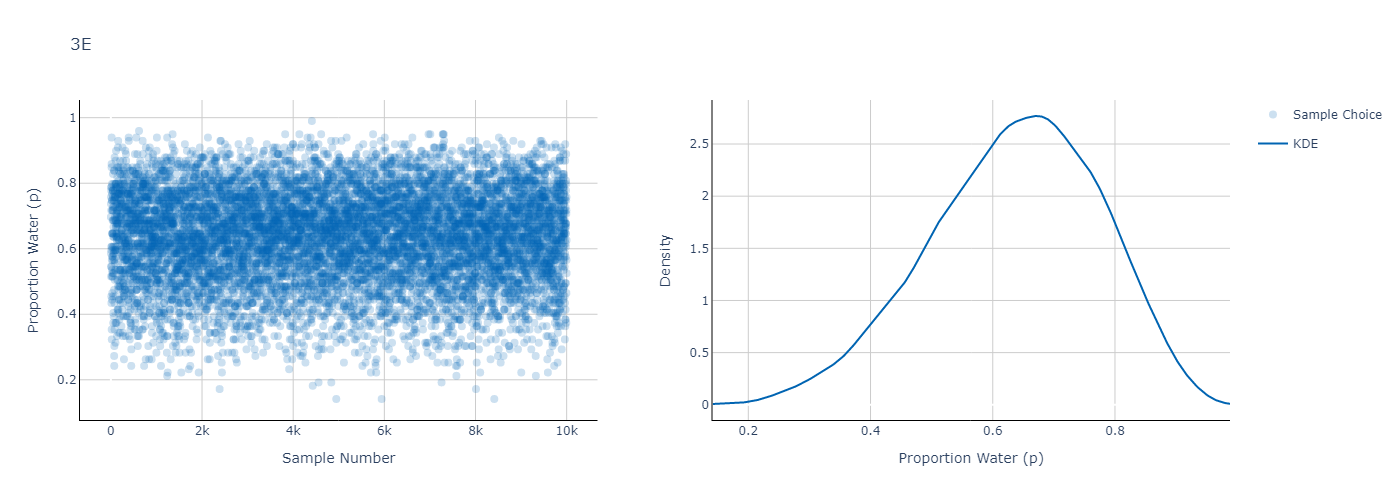

3E1. How much posterior probability lies below p = 0.2?
R: 9 | 0.0009

3E2. How much posterior probability lies above p = 0.8?
R: 1116 | 0.1116

3E3. How much posterior probability lies between p = 0.2 and p = 0.8?
R: 8875 | 0.8875

3E4. 20% of the posterior probability lies below which value of p?
R: 0.515

3E5. 20% of the posterior probability lies above which value of p?
R: 0.758

3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?
R: [0.51515152 0.77777778]

3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?
R: [0.49494949 0.76767677]



In [184]:
def binomial_posterior_grid(prior_func, grid_points:int, success:int, tosses:int):
    p_grid = np.linspace(0, 1, grid_points)
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    posterior = (likelihood*prior)/np.sum((likelihood*prior))
    return p_grid, posterior

def uniform_prior(grid_points:int):
    return np.repeat((1/grid_points), grid_points)

fig = plotly.subplots.make_subplots(
    rows=1, cols=2, row_titles=[]
)

grid, posterior = binomial_posterior_grid(uniform_prior, grid_points=100, success=6, tosses=9)
samples = np.random.choice(grid, p=posterior, size=int(10000), replace=True)
fig.add_trace(trace=go.Scatter(
    x=[i for i in range(len(samples))], y=samples,
    marker=dict(color='#0064b2', opacity=0.2, size=8),
    mode='markers',
    name='Sample Choice'
), row=1, col=1)
fig.add_trace(trace=ff.create_distplot(
    [samples], group_labels=['KDE'], colors=['#0064b2']
)['data'][1], row=1, col=2)
fig['data'][1]['name'] = 'KDE'
fig['data'][1]['showlegend'] = True

General.main_subplot_layout(fig, title='3E', width=1400, height=500)
fig['layout']['xaxis']['title']['text'] = 'Sample Number'
fig['layout']['yaxis']['title']['text'] = 'Proportion Water (p)'
fig['layout']['xaxis2']['title']['text'] = 'Proportion Water (p)'
fig['layout']['yaxis2']['title']['text'] = 'Density'

fig.show()

print(f'3E1. How much posterior probability lies below p = 0.2?\nR: {np.sum(samples < 0.2)} | {np.sum(samples < 0.2)/len(samples):.4f}\n')
print(f'3E2. How much posterior probability lies above p = 0.8?\nR: {np.sum(samples > 0.8)} | {np.sum(samples > 0.8)/len(samples):.4f}\n')
print(f'3E3. How much posterior probability lies between p = 0.2 and p = 0.8?\nR: {np.sum((samples > 0.2) & (samples < 0.8))} | {np.sum((samples > 0.2) & (samples < 0.8))/len(samples):.4f}\n')
print(f'3E4. 20% of the posterior probability lies below which value of p?\nR: {np.percentile(samples, 20):.3f}\n')
print(f'3E5. 20% of the posterior probability lies above which value of p?\nR: {np.percentile(samples, 80):.3f}\n')
print(f'3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?\nR: {az.hdi(samples, 0.66)}\n')
print(f'3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?\nR: {np.percentile(samples, [17,83])}\n')

### **3M1**
Suppose the globe tossing data had turned out to be **8 water in 15 tosses**. Construct the posterior distribution, using grid approximation. Use the same flat prior as before

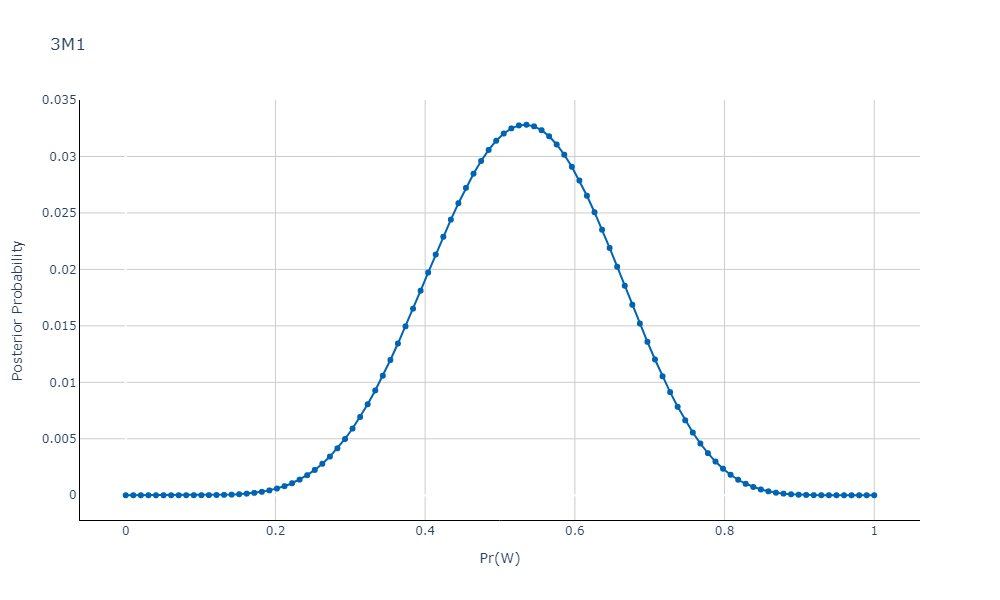

In [509]:
def binomial_posterior_grid(prior_func, grid_points:int, success:int, tosses:int):
    p_grid = np.linspace(0, 1, grid_points)
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    posterior = (likelihood*prior)/np.sum((likelihood*prior))
    return p_grid, posterior

def uniform_prior(grid_points:int):
    return np.repeat((1/grid_points), grid_points)

fig = plotly.subplots.make_subplots(
    rows=1, cols=2, row_titles=[]
)

grid, posterior = binomial_posterior_grid(uniform_prior, grid_points=100, success=8, tosses=15)
samples = np.random.choice(grid, p=posterior, size=int(10000), replace=True)
fig.add_trace(trace=go.Scatter(
    x=grid, y=posterior,
    marker=dict(color='#0064b2'),
    mode='lines+markers',
    name='W, W, W'
))

General.main_layout(fig, title='3M1', x='Pr(W)', y='Posterior Probability', width=1000, height=600)

### **3M2**
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the **90% HPDI for p**.

In [212]:
samples = np.random.choice(grid, p=posterior, size=10000, replace=True)
(f'HPDI 90%: {az.hdi(samples, 0.9)}')

'HPDI 90%: [0.34343434 0.72727273]'

### **3M3**
Construct a **posterior predictive check** for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing 8 water in 15 tosses?

In [455]:
def binomial_posterior_grid(prior_func, grid_points:int, success:int, tosses:int):
    p_grid = np.linspace(0, 1, grid_points)
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    posterior = (likelihood*prior)/np.sum((likelihood*prior))
    return p_grid, posterior

def uniform_prior(grid_points:int):
    return np.repeat((1/grid_points), grid_points)

grid, posterior = binomial_posterior_grid(uniform_prior, grid_points=100, success=8, tosses=15)
samples = np.random.choice(grid, p=posterior, size=10000, replace=True)

w = stats.binom.rvs(n=15, p=samples, size=len(samples))
# OR w = np.random.binomial(n=15, p=samples, size=len(samples))

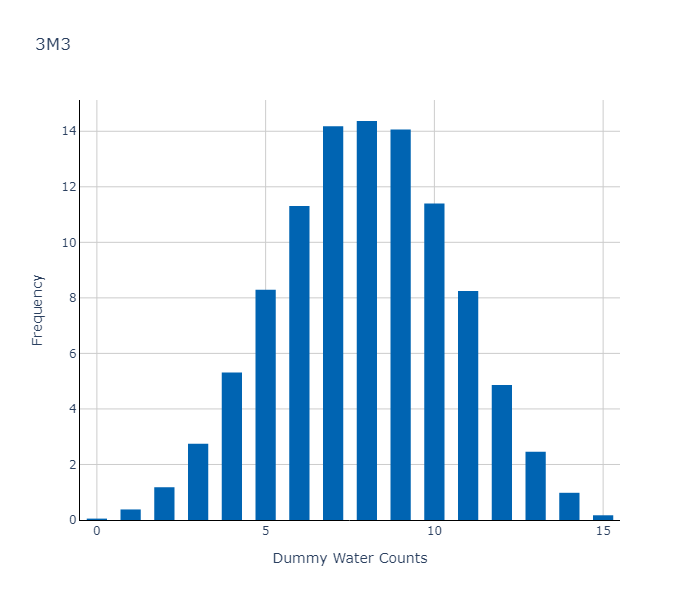

In [463]:
fig = go.Figure()

fig.add_trace(trace=go.Histogram(
    x=w, marker={'color':'#0064b2'}, histnorm='percent'
))

General.main_layout(fig, title='3M3', x='Dummy Water Counts', y='Frequency', bargap=0.4)

fig.show()

# This doesn’t mean it is a good model. But it does mean that model fitting worked.

### **3M4**
Using the posterior distribution constructed from the **new (Water=8 | Total=15) data**, now calculate the **probability of observing 6 water in 9 tosses**.

In [485]:
def binomial_posterior_grid(prior_func, grid_points:int, success:int, tosses:int):
    p_grid = np.linspace(0, 1, grid_points)
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    posterior = (likelihood*prior)/np.sum((likelihood*prior))
    return p_grid, posterior

def uniform_prior(grid_points:int):
    return np.repeat((1/grid_points), grid_points)

grid, posterior = binomial_posterior_grid(uniform_prior, grid_points=100, success=8, tosses=15)
samples = np.random.choice(grid, p=posterior, size=10000, replace=True)

w = stats.binom.rvs(n=9, p=samples, size=len(samples))
print(f'Pr(6W|9N) = {np.sum(w == 6)/len(w):.4f}')

Pr(6W|9N) = 0.1740


### **3H1**
**Introduction.**<br>
The practice problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.
```
birth1 <- c(1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1)

birth2 <- c(0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0)
```
So for example, the first family in the data reported a boy (1) and then a girl (0). The second family reported a girl (0) and then a boy (1). The third family reported two girls.<br>
Using grid approximation, **compute the posterior distribution for the probability of a birth being a boy**. Assume a uniform prior probability. Which parameter value maximizes the posterior probability?

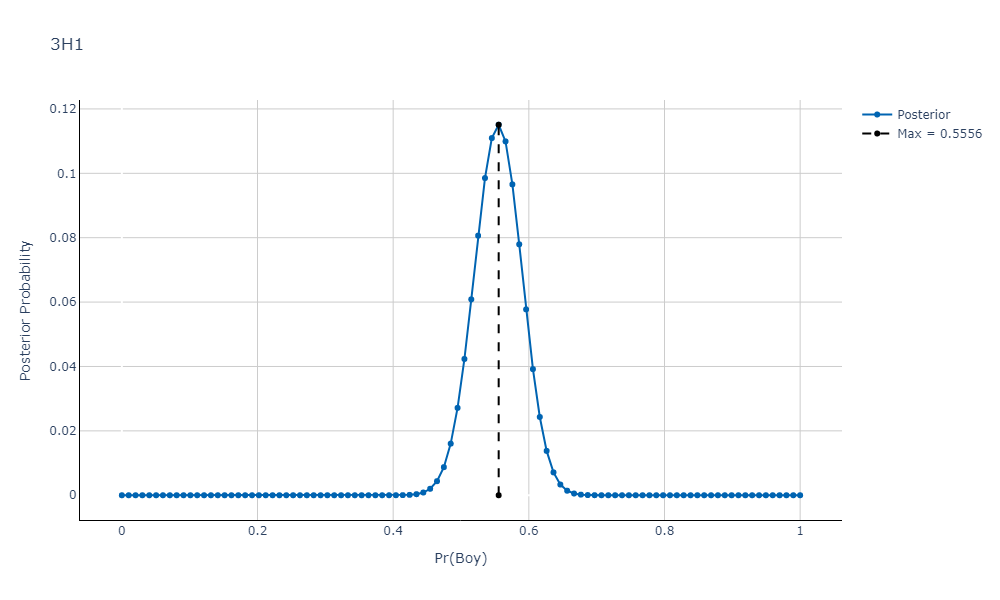

In [539]:
birth1 = [1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1]
birth2 = [0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0]

def binomial_posterior_grid(prior_func, grid_points:int, success:int, tosses:int):
    p_grid = np.linspace(0, 1, grid_points)
    prior = prior_func(grid_points)
    likelihood = stats.binom.pmf(success, tosses, p_grid)
    posterior = (likelihood*prior)/np.sum((likelihood*prior))
    return p_grid, posterior

def uniform_prior(grid_points:int):
    return np.repeat((1/grid_points), grid_points)

fig = go.Figure()

boys = sum(birth1) + sum(birth2)
grid, posterior = binomial_posterior_grid(uniform_prior, grid_points=100, success=boys, tosses=200)

fig.add_trace(trace=go.Scatter(
    x=grid, y=posterior,
    marker=dict(color='#0064b2'),
    mode='lines+markers',
    name='Posterior'
))
fig.add_trace(trace=go.Scatter(
    x=[grid[np.argmax(posterior)] for _ in range(2)], y=[0, np.max(posterior)],
    line=dict(color='black', dash='dash'),
    marker=dict(color='black'),
    mode='lines+markers',
    name=f'Max = {grid[np.argmax(posterior)]:.4f}'
))

General.main_layout(fig, title='3H1', x='Pr(Boy)', y='Posterior Probability', width=1000, height=600)
fig.show()